In [5]:
import matplotlib.pyplot as plt
import numpy as np
import jsonlines         
import glob

%matplotlib inline

In [6]:
_dev_file_path = '/Users/deniz/natural_questions/data/nq-dev-*.jsonl'
dev_files = glob.glob(_dev_file_path)
dev_examples = []
for _dev_file in dev_files:
    print(_dev_file)
    with jsonlines.open(_dev_file) as reader:
        for i, example in enumerate(reader):
            # pop ununsed keys
            del example['document_html']
            dev_examples.append(example)

/Users/deniz/natural_questions/data/nq-dev-00.jsonl
/Users/deniz/natural_questions/data/nq-dev-01.jsonl
/Users/deniz/natural_questions/data/nq-dev-02.jsonl
/Users/deniz/natural_questions/data/nq-dev-03.jsonl
/Users/deniz/natural_questions/data/nq-dev-04.jsonl


In [7]:
len(dev_examples)

7830

In [8]:
_train_file_path = '/Users/deniz/natural_questions/data/nq-train-*.jsonl'
train_files = glob.glob(_train_file_path)
train_examples = []
for _train_file in train_files:
    print(_train_file)
    with jsonlines.open(_train_file) as reader:
        for i, example in enumerate(reader):
            # pop ununsed keys
            del example['document_html']
            train_examples.append(example)

/Users/deniz/natural_questions/data/nq-train-46.jsonl


In [243]:
train_examples[0]['annotations']

[{'annotation_id': 5465334731230772859,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'}]

In [9]:
import json
# predictions: span basis
# post-processing takes the span answer with thihest score if there is one.
# if all spans are null-answer, take that. 
_pred_file_path = '/Users/deniz/natural_questions/data/predictions/predictions.json'
with open(_pred_file_path, "r") as read_file:
    span_predictions = json.load(read_file)
print(len(span_predictions))

# predictions: doc basis
import json
_dev_file_path = '/Users/deniz/natural_questions/data/predictions/final_predictions.json'
with open(_dev_file_path, "r") as read_file:
    data = json.load(read_file)
predictions = data['predictions']
print("the system output class balance: {}".format(len([p for p in predictions if not p['is_null_answer']])/len(predictions)))

495228
the system output class balance: 0.48952745849297574


In [174]:
span_predictions[0]

{'end_byte': 0,
 'example_id': -3290814144789249484,
 'score': 21,
 'start_byte': 0}

In [10]:
# only 11% of span predictions are non-null. 
# 85% precision, 60% recall.

len([sp for sp in span_predictions if sp['end_byte'] > 0 and sp['start_byte'] > 0]) / len(span_predictions)

0.11320644228516966

In [11]:
def get_short_annotations(example, is_train=True):
    """
    returns a list of annotations
    """
    gold_answers = []
    for annotation in example['annotations']: 
        if annotation['short_answers']:
            gold_answers.append({
              'end_byte': annotation['short_answers'][0]['end_byte'],
              'start_token': annotation['short_answers'][0]['start_token'],
              'end_token': annotation['short_answers'][0]['end_token'],
              'start_byte': annotation['short_answers'][0]['start_byte']  ,          
            })
    if not is_train and len(gold_answers) < 2:
        return None
    else:
        return gold_answers

In [12]:
gold_answers_dict = {}
length_of_the_dev_articles = {}
train_answers_dict = {}
length_of_the_train_articles = {}
for dev_example in dev_examples:
    length_of_the_dev_articles[dev_example['example_id']] = len(dev_example['document_tokens'])
    gold_answers_dict[dev_example['example_id']] = get_short_annotations(dev_example, False)
print("nb gold answers: {}".format(len(gold_answers_dict)))
for train_example in train_examples:
    length_of_the_train_articles[train_example['example_id']] = len(train_example['document_tokens'])
    train_answers_dict[train_example['example_id']] = get_short_annotations(train_example, True)
print("nb train data answers: {}".format(len(train_answers_dict)))

nb gold answers: 7830
nb train data answers: 6118


#### Span Lengths

In [13]:
import pandas as pd
def get_sa(answers_dict, length_of_the_articles):
    answers = list(answers_dict.values())
    start_tokens, end_tokens, text_length = [], [], []
    for example_id, answer_annotations in answers_dict.items():
        if answer_annotations:
            # take the first answer.
            first_annotation = answer_annotations[0]
            start_tokens.append(first_annotation['start_token'])
            end_tokens.append(first_annotation['end_token'])
            text_length.append(length_of_the_articles[example_id])
    return pd.DataFrame({'start_tokens': start_tokens, 'end_tokens': end_tokens, 'text_length': text_length})

In [14]:
train_answers_sa = get_sa(train_answers_dict, length_of_the_train_articles)
dev_answers_sa = get_sa(gold_answers_dict, length_of_the_dev_articles)
# print("nb gold answers with at least two answers: {}".format(len(start_tokens)))
# print("class balance in dev dataset: {}".format(len(start_tokens)/ len(gold_answers_dict)))

In [15]:
train_answers_sa.head()

,end_tokens,start_tokens,text_length
0,586,574,11899
1,789,788,18086
2,625,623,20885
3,336,334,4389
4,87,62,4075


In [16]:
# dev dataset needs at least 2 annotations out of 5. Still, dev have more answers. 
# 42% of documents in dev set has answers. THIS IS THE CLASS BALANCE OUT OF SAMPLE.
# 34% of documents in train set has answers (this is only one file though)
print("class balance in train dataset: {}".format(len(train_answers_sa)/ len(train_answers_dict)))
print("class balance in dev dataset: {}".format(len(dev_answers_sa)/ len(gold_answers_dict)))

class balance in train dataset: 0.3394900294213795
class balance in dev dataset: 0.42605363984674327


In [17]:
###########
## SPANS ##
###########

import pandas as pd
# given text nb sub tokens > nb_tokens. Approximate that here. 
batch_answer_length = (384 - 64) * .7
train_answers_sa['nb_spans'] = 1 + (train_answers_sa['text_length'] // batch_answer_length)
train_answers_sa['start_token_span'] = 1 + (train_answers_sa['start_tokens'] // batch_answer_length)
dev_answers_sa['nb_spans'] = 1 + (dev_answers_sa['text_length'] // batch_answer_length)
dev_answers_sa['start_token_span'] = 1 + (dev_answers_sa['start_tokens'] // batch_answer_length)

In [18]:
dev_answers_sa.head(30)

,end_tokens,start_tokens,text_length,nb_spans,start_token_span
0,251,245,10875,49.0,2.0
1,535,531,11584,52.0,3.0
2,1040,1032,5067,23.0,5.0
3,92,90,11376,51.0,1.0
4,6177,6173,14564,66.0,28.0
5,664,660,23899,107.0,3.0
6,98,96,16385,74.0,1.0
7,30,27,7192,33.0,1.0
8,195,194,32907,147.0,1.0
9,709,700,2514,12.0,4.0


In [19]:
# span in which answers lie
train_answers_spans = train_answers_sa.groupby(['start_token_span']).size()
dev_answers_spans = dev_answers_sa.groupby(['start_token_span']).size()

In [20]:
span_stats = pd.concat([train_answers_spans, 
           (train_answers_spans / train_answers_spans.sum()).cumsum(), 
           (train_answers_spans/len(train_answers_dict)).cumsum(),
           dev_answers_spans, 
           (dev_answers_spans / dev_answers_spans.sum()).cumsum(), 
           (dev_answers_spans/len(gold_answers_dict)).cumsum()],axis=1,
         ).fillna(0).head(20)
span_stats.columns = ['train_nb_spans','train_cum_perc_answers','train_cum_perc_examples',
                     'dev_nb_spans','dev_cum_perc_answers','dev_cum_perc_examples',]
span_stats

,train_nb_spans,train_cum_perc_answers,train_cum_perc_examples,dev_nb_spans,dev_cum_perc_answers,dev_cum_perc_examples
start_token_span,,,,,,
1.0,620.0,0.298507,0.101340,995.0,0.298261,0.127075
2.0,493.0,0.535869,0.181922,735.0,0.518585,0.220945
3.0,225.0,0.644198,0.218699,370.0,0.629496,0.268199
4.0,119.0,0.701493,0.238150,204.0,0.690647,0.294253
5.0,101.0,0.750120,0.254658,151.0,0.735911,0.313538
6.0,77.0,0.787193,0.267244,111.0,0.769185,0.327714
7.0,72.0,0.821858,0.279013,122.0,0.805755,0.343295
8.0,53.0,0.847376,0.287676,81.0,0.830036,0.353640
9.0,39.0,0.866153,0.294050,54.0,0.846223,0.360536


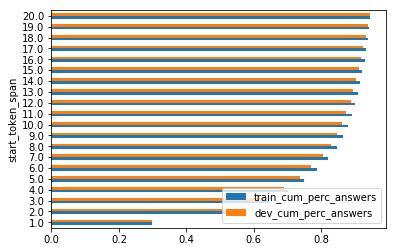

In [21]:
# observation -> 90% of answers are within ~14 spans.
# sampling from the first set of spans should also provide harder adverserial null answers.
# also: do not process the entire doc in dev. this would increase the false positive rate. 
span_stats[['train_cum_perc_answers','dev_cum_perc_answers']].plot(kind='barh')

In [33]:
# average nb of spans for each doc in dev
span_length = pd.DataFrame(np.array(list(length_of_the_train_articles.values()))/ batch_answer_length)
span_length.describe()

,0
count,6118.000000
mean,40.557567
std,37.631825
min,1.352679
25%,14.504464
50%,28.042411
75%,54.881696
max,361.566964


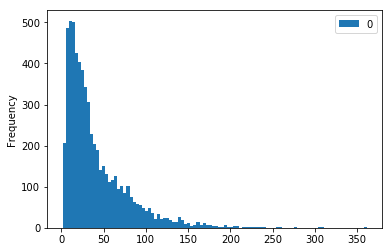

In [34]:
span_length.plot.hist(bins=100)

In [210]:
## answer span distribution. 
prediction_span_distribution = {}
for prediction in predictions:
    if prediction['short_answers'][0]['start_byte'] > 1:
        short_answer = prediction['short_answers'][0] # single answer
        document_tokens = [e for e in dev_examples if e['example_id'] == prediction['example_id']][0]['document_tokens']
        for i, t in enumerate(document_tokens):
            if t['start_byte'] >= short_answer['start_byte'] and t['end_byte'] <= short_answer['end_byte']:
                prediction_span_distribution[prediction['example_id']] = i
                break

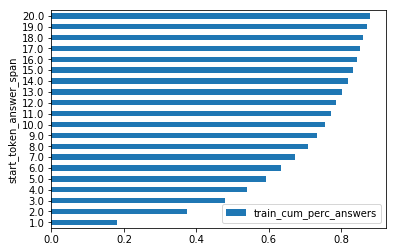

In [229]:
answer_spans = pd.DataFrame(1+np.array(list(prediction_span_distribution.values())) // batch_answer_length, columns=['start_token_answer_span'])
answer_spans = answer_spans.groupby(['start_token_answer_span']).size()
answer_span_stats = pd.concat([
           answer_spans, 
           (answer_spans / answer_spans.sum()).cumsum(), 
           (answer_spans/len(predictions)).cumsum()],axis=1,
         ).fillna(0).head(20)
answer_span_stats.columns = ['train_nb_spans','train_cum_perc_answers','train_cum_perc_examples']
answer_span_stats[['train_cum_perc_answers']].plot(kind='barh')

In [230]:
answer_span_stats

,train_nb_spans,train_cum_perc_answers,train_cum_perc_examples
start_token_answer_span,,,
1.0,696,0.181581,0.088889
2.0,741,0.374902,0.183525
3.0,403,0.480042,0.234994
4.0,228,0.539525,0.264112
5.0,199,0.591443,0.289527
6.0,161,0.633446,0.310089
7.0,151,0.672841,0.329374
8.0,138,0.708844,0.346999
9.0,91,0.732585,0.358621


### Error Analysis

In [35]:
def nonnull_span_equal(pspan, gspan):
    if pspan['end_byte'] == gspan['end_byte'] and pspan['start_byte'] == gspan['start_byte']:
      return True
    return False

def null_span_equal(pspan, gspan):
    if pspan['start_byte'] == -1 and pspan['end_byte'] == -1 and gspan is None: 
        return True
    return False
    
def span_set_equal(gold_answers, short_answers):
  """Make the spans are completely equal besides null spans."""
  # both null answers
  if any([null_span_equal(_pspan, gold_answers) for _pspan in short_answers]):
    return True
  if gold_answers is None:
    return False
  for gspan in gold_answers:
    # not finding gspan equal to any spans in gold_answers
    if any([nonnull_span_equal(pspan, gspan) for pspan in short_answers]):
      return True
  return False

In [36]:
# Test cases
short_answers = [{'end_byte': 80355,
  'end_token': 2703,
  'start_byte': 80287,
  'start_token': 2691}]
gold_answers = [{'end_byte': 80355,
  'end_token': 2703,
  'start_byte': 80287,
  'start_token': 2691}]
span_set_equal(gold_answers, short_answers)

True

In [37]:
short_answers = [{'end_byte': 8355,
  'end_token': 2703,
  'start_byte': 80287,
  'start_token': 2691}]
gold_answers = [{'end_byte': 80355,
  'end_token': 2703,
  'start_byte': 80287,
  'start_token': 2691}]
span_set_equal(gold_answers, short_answers)

False

In [38]:
short_answers = [{'end_byte': -1,
  'end_token': 2703,
  'start_byte': -1,
  'start_token': 2691}]
gold_answers = None
span_set_equal(gold_answers, short_answers)

True

In [39]:
short_answers = [{'end_byte': 8355,
  'end_token': 2703,
  'start_byte': 80287,
  'start_token': 2691}]
gold_answers = None
span_set_equal(gold_answers, short_answers)

False

In [65]:
cnt = 0
errors = []
for prediction in predictions:
    example_id = prediction['example_id']
    short_answers = prediction['short_answers']
    gold_answers = gold_answers_dict[example_id]
    _equal = span_set_equal(short_answers=short_answers, gold_answers=gold_answers)
    if not _equal:
        _errors = {'example_id': example_id,
                   'gold_answers': gold_answers,
                   'short_answers': short_answers
                  }
        errors.append(_errors)
len(errors), len(predictions)

(3384, 7830)

In [151]:
def get_answer_and_question(error):
    # model answer
    _doc= [e for e in dev_examples if e['example_id'] == error['example_id']][0]
    doc_tokens_for_error = _doc['document_tokens']
    _tokens = {i: t['token'] for i, t in enumerate(doc_tokens_for_error) if t['start_byte'] >= error['short_answers'][0]['start_byte'] and t['end_byte'] <= error['short_answers'][0]['end_byte']}
    model_answers = None
    model_span = None
    if _tokens:
        model_answers = ' '.join(list(_tokens.values()))
        model_span = (list(_tokens.keys())[0], list(_tokens.keys())[-1])
    # gold answer
    gold_answers = []
    gold_span = []
    gold_tokens = []
    if error['gold_answers']:
        for gold_answer in error['gold_answers']:
            _gold_tokens = {i: t['token'] for i, t in enumerate(doc_tokens_for_error) if t['start_byte'] >= gold_answer['start_byte'] and t['end_byte'] <= gold_answer['end_byte']}
            gold_tokens.append(_gold_tokens)
            gold_answers.append(' '.join(list(_gold_tokens.values())))
            gold_span.append((list(_gold_tokens.keys())[0], list(_gold_tokens.keys())[-1]))
    _dict = {#'doc_tokens_for_error': doc_tokens_for_error, 
             'model_answers': model_answers,
             'model_span': model_span,
             'gold_answers': gold_answers,
             'gold_span': gold_span,
             'url': _doc['document_url'],
             'question_text': [e for e in dev_examples if e['example_id'] == error['example_id']][0]['question_text']}
    return _dict

# What are types of mistakes?
# Do they happen at a particular place? - i.e. later spans
# Contextual vs Synthethic errors
# Recall issues(?)


In [126]:
# model span is much later.
error_analysis = get_answer_and_question(errors[3])
error_analysis

{'end_byte': 68445, 'start_token': 1032, 'end_token': 1040, 'start_byte': 68397}


{'gold_answers': ['Louis Mountbatten , 1st Earl Mountbatten of Burma',
  'Louis Mountbatten , 1st Earl Mountbatten of Burma',
  'Louis Mountbatten , 1st Earl Mountbatten of Burma'],
 'gold_span': [(1032, 1039), (1032, 1039), (1032, 1039)],
 'model_answers': 'C. Rajagopalachari',
 'model_span': (1607, 1608),
 'question_text': 'who was the governor general of india when country became independent',
 'url': 'https://en.wikipedia.org//w/index.php?title=Governor-General_of_India&amp;oldid=833230854'}

In [127]:
# model span is much later.
# grabs the correct type. does not understand the context
error_analysis = get_answer_and_question(errors[0])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': '− 30 ° C ( − 20 ° F )',
 'model_span': (855, 864),
 'question_text': 'what is the lowest recorded temperature on mount vinson',
 'url': 'https://en.wikipedia.org//w/index.php?title=Vinson_Massif&amp;oldid=836064305'}

In [128]:
# this looks correct?
error_analysis = get_answer_and_question(errors[1])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Amplitude modulation',
 'model_span': (2271, 2272),
 'question_text': 'which mode is used for short wave broadcast service',
 'url': 'https://en.wikipedia.org//w/index.php?title=Shortwave_radio&amp;oldid=838127903'}

In [113]:
errors[1]

{'example_id': -8817510910624892182,
 'gold_answers': None,
 'short_answers': [{'end_byte': 81846,
   'end_token': -1,
   'start_byte': 81826,
   'start_token': -1}]}

In [112]:
[d for d in dev_examples if d['example_id'] == errors[1]['example_id']][0]['annotations']

[{'annotation_id': 10957934160137332476,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 2807704282985816749,
  'long_answer': {'candidate_index': -1,
   'end_byte': -1,
   'end_token': -1,
   'start_byte': -1,
   'start_token': -1},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 5129692602407601925,
  'long_answer': {'candidate_index': 0,
   'end_byte': 57005,
   'end_token': 122,
   'start_byte': 56251,
   'start_token': 43},
  'short_answers': [],
  'yes_no_answer': 'NONE'},
 {'annotation_id': 4965838886380681126,
  'long_answer': {'candidate_index': 90,
   'end_byte': 104818,
   'end_token': 4593,
   'start_byte': 104066,
   'start_token': 4485},
  'short_answers': [{'end_byte': 104576,
    'end_token': 4570,
    'start_byte': 104572,
    'start_token': 4569},
   {'end_byte': 104639,
    'end_token': 4572,
    'star

In [129]:
# grabs a name again. 'human rights' comes up at the document once. this is how it comes up on google search results. 
# TODO: what is the score??
error_analysis = get_answer_and_question(errors[2])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Sir Henry Rawlinson',
 'model_span': (1581, 1583),
 'question_text': 'who wrote the first declaration of human rights',
 'url': 'https://en.wikipedia.org//w/index.php?title=Cyrus_Cylinder&amp;oldid=836606627'}

In [130]:
# this looks right!!!!
error_analysis = get_answer_and_question(errors[4])
error_analysis

{'end_byte': 43088, 'start_token': 90, 'end_token': 92, 'start_byte': 43078}


{'gold_answers': ['Dai Yongge',
  'Dai Yongge and Dai Xiuli ( majority )',
  'Xiu Li Dai',
  'Dai Yongge and Dai Xiuli ( majority )',
  'Xiu Li Dai'],
 'gold_span': [(90, 91), (90, 97), (3918, 3920), (90, 97), (3918, 3920)],
 'model_answers': 'Dai Yongge and Dai Xiuli',
 'model_span': (90, 94),
 'question_text': 'who is the owner of reading football club',
 'url': 'https://en.wikipedia.org//w/index.php?title=Reading_F.C.&amp;oldid=819311942'}

In [131]:
# this looks right!
error_analysis = get_answer_and_question(errors[5])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Walterboro Army Airfield',
 'model_span': (7704, 7706),
 'question_text': 'where did the first african american air force unit train',
 'url': 'https://en.wikipedia.org//w/index.php?title=Tuskegee_Airmen&amp;oldid=838231620'}

In [132]:
# this answer is certainly missing the context
error_analysis = get_answer_and_question(errors[6])
error_analysis

{'end_byte': 132681, 'start_token': 6173, 'end_token': 6177, 'start_byte': 132663}


{'gold_answers': ['February 1 , 2018',
  'February 1 , 2018',
  'February 1 , 2018'],
 'gold_span': [(6173, 6176), (6173, 6176), (6173, 6176)],
 'model_answers': 'February 8 , 2018',
 'model_span': (6213, 6216),
 'question_text': 'when is the next scandal episode coming out',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_Scandal_episodes&amp;oldid=821580194'}

In [134]:
# looks correct on the long answre
error_analysis = get_answer_and_question(errors[7])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': "The song relates to both the Old and New Testaments . The verses reflect the Israelites ' escape out of Egypt as found in Exodus 14 . The chorus refers to healing : see John 5 : 4 , `` For an angel went down at a certain season into the pool , and troubled the water : whosoever then first after the troubling of the water stepped in was made whole of whatsoever disease he had . ''",
 'model_span': (388, 466),
 'question_text': 'meaning of lyrics to wade in the water',
 'url': 'https://en.wikipedia.org//w/index.php?title=Wade_in_the_Water&amp;oldid=833167717'}

In [135]:
# looks correct! what
error_analysis = get_answer_and_question(errors[8])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'to safeguard the merit system by protecting federal employees and applicants from prohibited personnel practices , especially reprisal for whistleblowing',
 'model_span': (542, 561),
 'question_text': 'the primary reason for the creation of federal whistleblower statutes was to',
 'url': 'https://en.wikipedia.org//w/index.php?title=Whistleblower_Protection_Act&amp;oldid=838141336'}

In [136]:
# looks correct! though the male/female context is probably missing because it is a non-English name
error_analysis = get_answer_and_question(errors[9])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Alladi Krishnaswamy Iyer',
 'model_span': (556, 558),
 'question_text': 'who was the first lady nominated member of the rajya sabha',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_nominated_members_of_Rajya_Sabha&amp;oldid=818220921'}

In [137]:
error_analysis = get_answer_and_question(errors[10])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': '2017',
 'model_span': (3085, 3085),
 'question_text': 'when was the last time the world series went less than 7 games',
 'url': 'https://en.wikipedia.org//w/index.php?title=Game_seven&amp;oldid=813197908'}

In [138]:
# this is the wrong wikipedia article. at that time, kobe was probably the top in the list. 
error_analysis = get_answer_and_question(errors[11])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Kobe Bryant',
 'model_span': (391, 392),
 'question_text': 'who has played for the most nba teams',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_NBA_players_who_have_spent_their_entire_career_with_one_franchise&amp;oldid=806218522'}

In [139]:
# hard one.
error_analysis = get_answer_and_question(errors[12])
error_analysis

{'gold_answers': ['28.0. 0.137', '28.0. 0.137'],
 'gold_span': [(96, 97), (3589, 3590)],
 'model_answers': 'Version 9',
 'model_span': (4037, 4038),
 'question_text': 'what is the most current adobe flash player version',
 'url': 'https://en.wikipedia.org//w/index.php?title=Adobe_Flash_Player&amp;oldid=821558952'}

In [140]:
# this is right too. just repetitions
error_analysis = get_answer_and_question(errors[13])
error_analysis

{'gold_answers': ['Pyotr Ilyich Tchaikovsky',
  'Pyotr Ilyich Tchaikovsky',
  'Pyotr Ilyich Tchaikovsky',
  'Pyotr Ilyich Tchaikovsky',
  'Pyotr Ilyich Tchaikovsky'],
 'gold_span': [(27, 29), (27, 29), (27, 29), (27, 29), (27, 29)],
 'model_answers': 'Pyotr Ilyich Tchaikovsky',
 'model_span': (103, 105),
 'question_text': 'swan lake the sleeping beauty and the nutcracker are three famous ballets by',
 'url': 'https://en.wikipedia.org//w/index.php?title=The_Sleeping_Beauty_(ballet)&amp;oldid=820890862'}

In [141]:
# probably picks up: Most consecutive touchdowns, none intercepted, home
error_analysis = get_answer_and_question(errors[14])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Aaron Rodgers',
 'model_span': (15127, 15128),
 'question_text': 'who has scored the most touchdowns this year',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_National_Football_League_records_(individual)&amp;oldid=821726501'}

In [142]:
# this is a mistake.
error_analysis = get_answer_and_question(errors[15])
error_analysis

{'gold_answers': ['291', '291 episodes', '291', '291'],
 'gold_span': [(194, 194), (194, 195), (210, 210), (210, 210)],
 'model_answers': '200 - 291',
 'model_span': (282, 284),
 'question_text': 'how many episodes are there in dragon ball z',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_Dragon_Ball_Z_episodes&amp;oldid=836279411'}

In [143]:
# also looks correct
error_analysis = get_answer_and_question(errors[16])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Character </Th> <Th> Rank / Position </Th> <Th colspan="3"> Seasons </Th> <Th> Notes </Th> </Tr> <Tr> <Th> Regular </Th> <Th> Recurring </Th> <Th> Guest </Th> </Tr> <Tr> <Td> Christopher Meloni </Td> <Td> Elliot Stabler </Td> <Td> Detective </Td> <Td> 1 -- 12 </Td> <Td> </Td> <Td> </Td> <Td> </Td> </Tr> <Tr> <Td> Mariska Hargitay </Td> <Td> Olivia Benson </Td> <Td> Lieutenant </Td> <Td> 1 -- </Td> <Td> </Td> <Td> </Td> <Td> </Td> </Tr> <Tr> <Td> Richard Belzer </Td> <Td> John Munch </Td> <Td> DA Investigator </Td> <Td> 1 -- 15 </Td> <Td> </Td> <Td> 15 , 17 </Td> <Td> </Td> </Tr> <Tr> <Td> Dann Florek </Td> <Td> Donald Cragen </Td> <Td> Captain </Td> <Td> 1 -- 15 </Td> <Td> </Td> <Td> 16 </Td> <Td> </Td> </Tr> <Tr> <Td> Michelle Hurd </Td> <Td> Monique Jeffries </Td> <Td> Detective </Td> <Td> 1 -- 2 </Td> <Td> </Td> <Td> </Td> <Td> </Td> </Tr> <Tr> <Td> Stephanie March </Td> <Td> Alexandra Cabot </Td> <Td> Assistant District Atto

In [144]:
# also looks correct!!!
# Tyler told Record Mirror that she thought the song was about "someone who wants to love so badly she's lying there in complete darkness."[9]
error_analysis = get_answer_and_question(errors[17])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': "`` someone who wants to love so badly she 's lying there in complete darkness",
 'model_span': (1093, 1107),
 'question_text': 'what is the total eclipse of the heart video about',
 'url': 'https://en.wikipedia.org//w/index.php?title=Total_Eclipse_of_the_Heart&amp;oldid=822305104'}

In [145]:
error_analysis = get_answer_and_question(errors[18])
error_analysis

{'gold_answers': ['The planner Raymond Unwin and the architect Barry Parker',
  'planner Raymond Unwin and the architect Barry Parker',
  'planner Raymond Unwin',
  'Raymond Unwin'],
 'gold_span': [(700, 708), (701, 708), (701, 703), (702, 703)],
 'model_answers': 'York philanthropist , Joseph Rowntree',
 'model_span': (480, 484),
 'question_text': 'who designed the garden city of new earswick',
 'url': 'https://en.wikipedia.org//w/index.php?title=New_Earswick&amp;oldid=826057861'}

In [152]:
# RECALL ISSUE. 
error_analysis = get_answer_and_question(errors[19])
error_analysis

{'gold_answers': ['photoreceptor proteins that sense light',
  'eyespots',
  "photoreceptor proteins that sense light , found even in unicellular organisms , called `` eyespots ''"],
 'gold_span': [(1270, 1274), (1284, 1284), (1270, 1285)],
 'model_answers': None,
 'model_span': None,
 'question_text': 'what is the first step in the evolution of the eye',
 'url': 'https://en.wikipedia.org//w/index.php?title=Evolution_of_the_eye&amp;oldid=838517245'}

In [153]:
# again, picks the right synthax / NER but context is way off. !!!!!
error_analysis = get_answer_and_question(errors[20])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'In the ninth season',
 'model_span': (638, 641),
 'question_text': "when does karev die in grey's anatomy",
 'url': 'https://en.wikipedia.org//w/index.php?title=Alex_Karev&amp;oldid=806916198'}

In [154]:
# recall. false negative
error_analysis = get_answer_and_question(errors[21])
error_analysis

{'gold_answers': ['Yaya Touré', 'Yaya Touré', 'Yaya Touré', 'Yaya Touré'],
 'gold_span': [(2968, 2969), (2968, 2969), (2968, 2969), (2968, 2969)],
 'model_answers': None,
 'model_span': None,
 'question_text': 'who was named african footballer of the year 2014',
 'url': 'https://en.wikipedia.org//w/index.php?title=African_Footballer_of_the_Year&amp;oldid=822578197'}

In [155]:
# material. but wrong one.
error_analysis = get_answer_and_question(errors[22])
error_analysis

{'gold_answers': ['lithium', 'Lithium'],
 'gold_span': [(6974, 6974), (1594, 1594)],
 'model_answers': 'tritium',
 'model_span': (8073, 8073),
 'question_text': 'what is the main mineral in lithium batteries',
 'url': 'https://en.wikipedia.org//w/index.php?title=Lithium&amp;oldid=819518707'}

In [156]:
# recall. false negative
error_analysis = get_answer_and_question(errors[23])
error_analysis

{'gold_answers': ['constitutional right', 'constitutional right'],
 'gold_span': [(6863, 6864), (6863, 6864)],
 'model_answers': None,
 'model_span': None,
 'question_text': 'right to property according to the constitution of india is a',
 'url': 'https://en.wikipedia.org//w/index.php?title=Fundamental_rights_in_India&amp;oldid=837658190'}

In [158]:
# this looks correct
error_analysis = get_answer_and_question(errors[24])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'No one both contracted and died of Ebola virus disease while in the United States . No new cases have been diagnosed in the United States since Craig Spencer was released from a New York City hospital on November 11 , 2014 .',
 'model_span': (548, 590),
 'question_text': 'did anyone die from ebola in the us',
 'url': 'https://en.wikipedia.org//w/index.php?title=Ebola_virus_cases_in_the_United_States&amp;oldid=834124413'}

In [159]:
# this looks correct
error_analysis = get_answer_and_question(errors[25])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Tulsa , Oklahoma',
 'model_span': (289, 291),
 'question_text': 'where do the greasers live in the outsiders',
 'url': 'https://en.wikipedia.org//w/index.php?title=The_Outsiders_(novel)&amp;oldid=837955086'}

In [162]:
error_analysis = get_answer_and_question(errors[26])
error_analysis

{'gold_answers': ['the Yakima ( Washington ) and Willamette ( Oregon ) valleys',
  'the leading potato - growing states in the United States',
  'the Yakima ( Washington ) and Willamette ( Oregon ) valleys',
  'Washington',
  'Yakima ( Washington )'],
 'gold_span': [(1149, 1159),
  (1043, 1052),
  (1149, 1159),
  (1152, 1152),
  (1150, 1153)],
 'model_answers': None,
 'model_span': None,
 'question_text': 'where do they grow hops in the us',
 'url': 'https://en.wikipedia.org//w/index.php?title=Hops&amp;oldid=836763018'}

In [164]:
# this is way at the end. maybe boost answers in earlier spans. 
error_analysis = get_answer_and_question(errors[27])
error_analysis

{'gold_answers': ['Spike',
  'Spike',
  'Spike , occasionally referred to as Butch or Killer'],
 'gold_span': [(1520, 1520), (1520, 1520), (1520, 1528)],
 'model_answers': 'Rumpley',
 'model_span': (8285, 8285),
 'question_text': "what's the dog's name on tom and jerry",
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_Tom_and_Jerry_characters&amp;oldid=812821786'}

In [165]:
# "appeared" doesn't mean she plays nikki in the movie"
error_analysis = get_answer_and_question(errors[28])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Vaugier appeared in Need for Speed : Carbon as Nikki . She is the girlfriend of the antagonist in the game ( love interest of the protagonist ) .',
 'model_span': (948, 976),
 'question_text': 'who plays nikki in need for speed carbon',
 'url': 'https://en.wikipedia.org//w/index.php?title=Emmanuelle_Vaugier&amp;oldid=836763004'}

In [166]:
# THIS LOOKS CORRECT TOO!!!
error_analysis = get_answer_and_question(errors[29])
error_analysis

{'gold_answers': ['Nigeria', 'Nigeria', 'Nigeria', 'Nigeria'],
 'gold_span': [(19, 19), (19, 19), (19, 19), (19, 19)],
 'model_answers': 'Angola and Nigeria',
 'model_span': (1635, 1637),
 'question_text': 'in which regions are most of africa petroleum and natural gas found',
 'url': 'https://en.wikipedia.org//w/index.php?title=Petroleum_industry_in_Nigeria&amp;oldid=834244345'}

In [167]:
# CORRECT!!!!
error_analysis = get_answer_and_question(errors[30])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Platform 13',
 'model_span': (5462, 5463),
 'question_text': 'what platform is sandringham line at flinders st',
 'url': 'https://en.wikipedia.org//w/index.php?title=Flinders_Street_railway_station&amp;oldid=819098902'}

In [168]:
# CORRECT!!!! CAN ANNOTATIONS BE IMPROVED ?
error_analysis = get_answer_and_question(errors[31])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Barbara Eden Nanette Fabray Ronny Cox Louis Nye Susan Swift Pat Paulsen',
 'model_span': (74, 85),
 'question_text': 'who played in the movie harper valley pta',
 'url': 'https://en.wikipedia.org//w/index.php?title=Harper_Valley_PTA_(film)&amp;oldid=818590841'}

In [169]:
# the 'synthex` is wrong. bad error.
error_analysis = get_answer_and_question(errors[32])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'wild oysters',
 'model_span': (3092, 3093),
 'question_text': 'in which sea pearl is found in india',
 'url': 'https://en.wikipedia.org//w/index.php?title=Pearl&amp;oldid=835416381'}

In [170]:
# the 'synthex` is wrong. bad error.
# EXPLORE IT FURTHER.
error_analysis = get_answer_and_question(errors[33])
error_analysis

{'gold_answers': ['China', 'China', 'China', 'China', 'China'],
 'gold_span': [(537, 537), (537, 537), (537, 537), (537, 537), (537, 537)],
 'model_answers': None,
 'model_span': None,
 'question_text': 'panda is a national animal of which country',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_national_animals&amp;oldid=837910587'}

In [171]:
error_analysis = get_answer_and_question(errors[34])
error_analysis

{'gold_answers': ['14', '14', '14', '14'],
 'gold_span': [(68, 68), (235, 235), (235, 235), (235, 235)],
 'model_answers': '14 member countries',
 'model_span': (944, 946),
 'question_text': 'how many countries are a part of opec',
 'url': 'https://en.wikipedia.org//w/index.php?title=OPEC&amp;oldid=834259589'}

In [172]:
# MUCH LATER.
error_analysis = get_answer_and_question(errors[35])
error_analysis

{'gold_answers': ['light utility vehicles', 'sport utility vehicles'],
 'gold_span': [(685, 687), (282, 284)],
 'model_answers': 'four - wheel drive',
 'model_span': (2931, 2934),
 'question_text': 'what type of car is a jeep considered',
 'url': 'https://en.wikipedia.org//w/index.php?title=Jeep&amp;oldid=837725447'}

In [231]:
# KIND OF TRUE
error_analysis = get_answer_and_question(errors[36])
error_analysis

{'gold_answers': ['between the Eastern Ghats and the Bay of Bengal',
  'from Tamil Nadu in the south to West Bengal in the north through Andhra Pradesh and Odisha',
  'between the Eastern Ghats and the Bay of Bengal'],
 'gold_span': [(89, 97), (111, 127), (89, 97)],
 'model_answers': 'between the Eastern Ghats and the Bay of Bengal . It is wider and leveled than the western coastal plains and stretches from Tamil Nadu in the south to West Bengal in the north through Andhra Pradesh and Odisha',
 'model_span': (89, 127),
 'question_text': 'where are the coastal plains of india situated',
 'url': 'https://en.wikipedia.org//w/index.php?title=Eastern_coastal_plains&amp;oldid=812520937'}

In [232]:
#  TRUE
error_analysis = get_answer_and_question(errors[37])
error_analysis

{'gold_answers': ["Destiny 's Child",
  'Solange Knowles',
  "Destiny 's Child",
  'Solange Knowles'],
 'gold_span': [(187, 189), (184, 185), (187, 189), (184, 185)],
 'model_answers': "Solange Knowles & Destiny 's Child",
 'model_span': (184, 189),
 'question_text': 'who sings the theme song for the proud family',
 'url': 'https://en.wikipedia.org//w/index.php?title=The_Proud_Family_(soundtrack)&amp;oldid=638462881'}

In [233]:
error_analysis = get_answer_and_question(errors[38])
error_analysis

{'gold_answers': ['almost certainly wrote his version of the title role for his fellow actor , Richard Burbage',
  'his fellow actor , Richard Burbage',
  "for his fellow actor , Richard Burbage , the leading tragedian of Shakespeare 's time",
  'his fellow actor , Richard Burbage'],
 'gold_span': [(335, 350), (345, 350), (344, 358), (345, 350)],
 'model_answers': 'Richard Burbage',
 'model_span': (9965, 9966),
 'question_text': 'who did shakespeare write his play hamlet for',
 'url': 'https://en.wikipedia.org//w/index.php?title=Hamlet&amp;oldid=838253610'}

In [234]:
error_analysis = get_answer_and_question(errors[39])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Robert Frost',
 'model_span': (41, 42),
 'question_text': 'who wrote the poem the woods are lovely dark and deep',
 'url': 'https://en.wikipedia.org//w/index.php?title=Stopping_by_Woods_on_a_Snowy_Evening&amp;oldid=826525203'}

In [235]:
# Tom Stagg (Jonjo O'Neill), Rose Stagg's husband
error_analysis = get_answer_and_question(errors[40])
error_analysis

{'gold_answers': ['a woman who had a sexual relationship with Paul whilst at university',
  'Valene Kane',
  'Valene Kane',
  'Valene Kane'],
 'gold_span': [(2691, 2702), (604, 605), (604, 605), (604, 605)],
 'model_answers': 'Tom Stagg',
 'model_span': (3224, 3225),
 'question_text': 'who is rose in the fall season 2',
 'url': 'https://en.wikipedia.org//w/index.php?title=List_of_The_Fall_characters&amp;oldid=811099612'}

In [236]:
error_analysis = get_answer_and_question(errors[41])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': "The Sea of Monsters is a fantasy - adventure novel based on Greek mythology written by Rick Riordan and published in 2006 . It is the second novel in the Percy Jackson & the Olympians series and the sequel to The Lightning Thief . This book chronicles the adventures of thirteen - year - old demigod Percy Jackson as he and his friends rescue his satyr friend Grover from the Cyclops Polyphemus and save the camp from a Titan 's attack by bringing the Golden Fleece to cure Thalia 's poisoned pine tree .",
 'model_span': (240, 333),
 'question_text': 'percy jackson and the olympians sea of monsters summary',
 'url': 'https://en.wikipedia.org//w/index.php?title=The_Sea_of_Monsters&amp;oldid=821188590'}

In [237]:
# TRUE!
error_analysis = get_answer_and_question(errors[42])
error_analysis

{'gold_answers': [],
 'gold_span': [],
 'model_answers': 'Emilio Scotto',
 'model_span': (103, 104),
 'question_text': 'who holds the record for longest motorcycle jump',
 'url': 'https://en.wikipedia.org//w/index.php?title=Emilio_Scotto&amp;oldid=833804963'}

In [238]:
# True but much later.
error_analysis = get_answer_and_question(errors[43])
error_analysis

{'gold_answers': ['Tracy McConnell',
  'Tracy McConnell',
  'Tracy McConnell',
  'Tracy McConnell',
  'Tracy McConnell'],
 'gold_span': [(213, 214), (258, 259), (213, 214), (213, 214), (213, 214)],
 'model_answers': 'Tracy McConnell',
 'model_span': (2457, 2458),
 'question_text': 'who turned out to be the mother on how i met your mother',
 'url': 'https://en.wikipedia.org//w/index.php?title=The_Mother_(How_I_Met_Your_Mother)&amp;oldid=802354471'}

In [239]:
# True but much later.
error_analysis = get_answer_and_question(errors[44])
error_analysis

{'gold_answers': ['Jean - Paul Valley ( a.k.a. Azrael )',
  'an apprentice named Jean - Paul Valley ( a.k.a. Azrael )',
  'an apprentice named Jean - Paul Valley ( a.k.a. Azrael )',
  'Jean - Paul Valley ( a.k.a. Azrael )'],
 'gold_span': [(527, 534), (524, 534), (524, 534), (527, 534)],
 'model_answers': 'Bruce Wayne',
 'model_span': (493, 494),
 'question_text': 'who took over for batman when his back was broken',
 'url': 'https://en.wikipedia.org//w/index.php?title=Batman:_Knightfall&amp;oldid=836456522'}